**Automatic Apparent Age Estimation **- ABINAYA VINOTH & APARAJITHA SENTHIL KUMAR

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.18.0


In [ ]:
# downloading the data
!wget http://data.chalearnlap.cvc.uab.cat/Colab_MFPDS/app_data_reduced.zip

# decompressing the data
from zipfile import ZipFile

with ZipFile('app_data_reduced.zip','r') as zip:
   zip.extractall()
   print('Data decompressed successfully')

# removing the .zip file after extraction to clean space
!rm app_data_reduced.zip

--2025-03-07 17:47:37--  http://data.chalearnlap.cvc.uab.cat/Colab_MFPDS/app_data_reduced.zip
Resolving data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)... 158.109.8.102
Connecting to data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)|158.109.8.102|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 619961901 (591M) [application/zip]
Saving to: ‘app_data_reduced.zip’

app_data_reduced.zi 100%[===================>] 591.24M  7.21MB/s    in 2m 7s   

2025-03-07 17:49:44 (4.65 MB/s) - ‘app_data_reduced.zip’ saved [619961901/619961901]

Data decompressed successfully


In [ ]:
import numpy as np

# loading the train data (with labels)
X_train = np.load('./data/data_train.npy')
Y_train = np.load('./data/labels_train.npy')
M_train = np.load('./data/meta_data_train.npy')

# loading the validation data (with labels)
X_valid = np.load('./data/data_valid.npy')
Y_valid = np.load('./data/labels_valid.npy')
M_valid = np.load('./data/meta_data_valid.npy')

# train labels are real numbers, ranging from ~0.9 to ~89 (years old);
# we will re-scale the labels to [0,1] by using a normalization factor of 100,
# assuming there is no sample with age > 100.
Y_train = Y_train/100
Y_valid = Y_valid/100

print('Train data size and shape', X_train.shape)
print('Train labels size and shape', Y_train.shape)
print('Train metadata size and shape', M_train.shape)
print('----')
print('Valid data size and shape', X_valid.shape)
print('Valid labels size and shape', Y_valid.shape)
print('Valid metadata size and shape', M_valid.shape)

Train data size and shape (2845, 224, 224, 3)
Train labels size and shape (2845,)
Train metadata size and shape (2845, 3)
----
Valid data size and shape (1037, 224, 224, 3)
Valid labels size and shape (1037,)
Valid metadata size and shape (1037, 3)


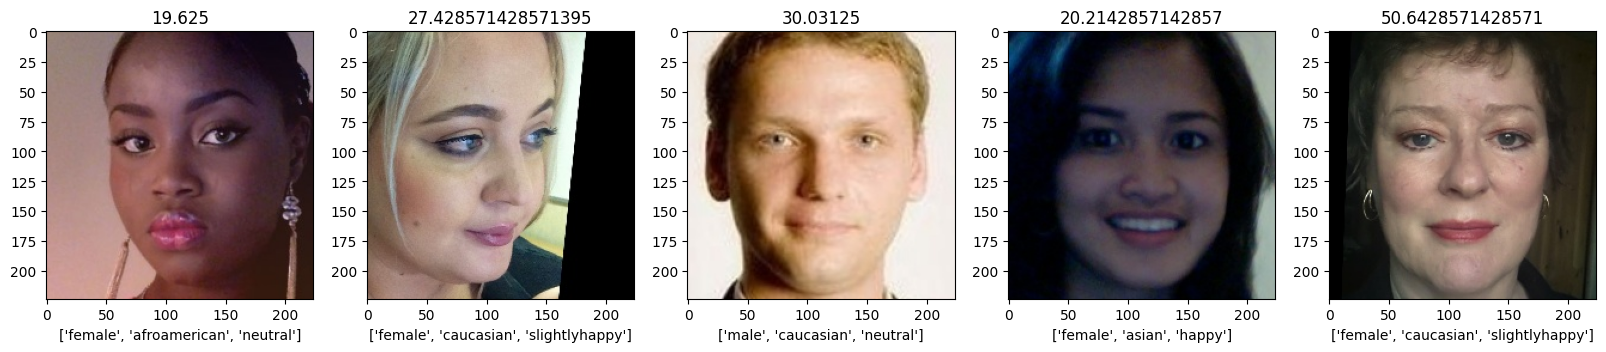

In [ ]:
import cv2
import random
from matplotlib import pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 20))
for i, ax in enumerate(axes):
    idx = random.randint(0, len(X_train))
    ax.imshow(cv2.cvtColor(X_train[idx,:,:,:], cv2.COLOR_BGR2RGB))
    ax.set_title(Y_train[idx]*100)
    ax.set(xlabel=[M_train[idx][0],M_train[idx][1],M_train[idx][2]])



In [ ]:
# downloading the data
!wget http://data.chalearnlap.cvc.uab.cat/Colab_MFPDS/vggface2_Keras.zip

# decompressing the data
with ZipFile('vggface2_Keras.zip','r') as zip:
   zip.extractall()
   print('Model decompressed successfully')

# removing the .zip file after extraction  to clean space
!rm vggface2_Keras.zip

--2025-03-07 17:50:05--  http://data.chalearnlap.cvc.uab.cat/Colab_MFPDS/vggface2_Keras.zip
Resolving data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)... 158.109.8.102
Connecting to data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)|158.109.8.102|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107894237 (103M) [application/zip]
Saving to: ‘vggface2_Keras.zip’

vggface2_Keras.zip  100%[===================>] 102.90M  4.69MB/s    in 25s     

2025-03-07 17:50:30 (4.17 MB/s) - ‘vggface2_Keras.zip’ saved [107894237/107894237]

Model decompressed successfully


In [ ]:
import h5py

# loading the pretrained model
model = tf_keras.models.load_model('vggface2_Keras.h5')

# print the model summary
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 base_input (InputLayer)     [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1/7x7_s2 (Conv2D)       (None, 112, 112, 64)         9408      ['base_input[0][0]']          
                                                                                                  
 conv1/7x7_s2/bn (BatchNorm  (None, 112, 112, 64)         256       ['conv1/7x7_s2[0][0]']        
 alization)                                                                                       
                                                                                                  
 activation_1 (Activation)   (None, 112, 112, 64)         0         ['conv1/7x7_s2/bn[0][0]'

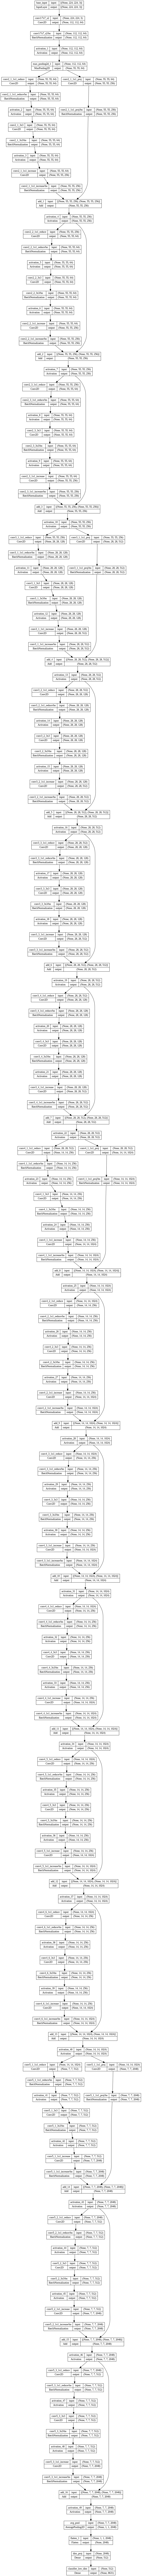

In [ ]:
tf_keras.utils.plot_model(model, show_shapes=True)

In [ ]:
from tf_keras.layers import Dense, Activation, Dropout

# Using the FC layer before the 'classifier_low_dim' layer as feature vector
fc_512 = model.get_layer('dim_proj').output

# Adding a dropout layer to minimize overfitting problems
dp_layer = tf_keras.layers.Dropout(0.5)(fc_512)

# Adding a few hidden FC layers to learn hidden representations
fc_128 = tf_keras.layers.Dense(128, activation='relu', name='f_128')(dp_layer)
fc_32 = tf_keras.layers.Dense(32, activation='relu', name='f_32')(fc_128)

# Including an additional FC layer with sigmoid activation, used to regress the apparent age
output = tf_keras.layers.Dense(1, activation='sigmoid', name='predict')(fc_32)

# Building and printing the final model
model = tf_keras.models.Model(inputs=model.get_layer('base_input').output, outputs=output)
print(model.summary())

# Save the base model for tuning
base_model = model  # This will be our source model for tuning

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 base_input (InputLayer)     [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1/7x7_s2 (Conv2D)       (None, 112, 112, 64)         9408      ['base_input[0][0]']          
                                                                                                  
 conv1/7x7_s2/bn (BatchNorm  (None, 112, 112, 64)         256       ['conv1/7x7_s2[0][0]']        
 alization)                                                                                       
                                                                                                  
 activation_1 (Activation)   (None, 112, 112, 64)         0         ['conv1/7x7_s2/bn[0][0]'] 

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.models import Model

def create_tuned_model(base_model, dropout_rate):
    # Ensure base model is not trainable
    base_model.trainable = False

    # Define new input layer (must match base model's expected input)
    new_input = Input(shape=(224, 224, 3))  # Adjust based on dataset

    # Pass input through base model
    base_output = base_model(new_input, training=False)

    # Handle case where base_model returns multiple outputs
    if isinstance(base_output, (tuple, list)):
        base_output = base_output[0]  # Extract first tensor if there are multiple outputs

    # Ensure the output is 2D by applying GlobalAveragePooling2D if needed
    if len(base_output.shape) == 4:
        base_output = GlobalAveragePooling2D()(base_output)

    # Apply dropout
    dp_layer = Dropout(dropout_rate)(base_output)

    # Fully Connected Layers
    fc_128 = Dense(128, activation='relu', name='f_128')(dp_layer)
    fc_32 = Dense(32, activation='relu', name='f_32')(fc_128)

    # Output layer for regression
    output = Dense(1, activation='sigmoid', name='predict')(fc_32)

    # Build the new model using the new input layer
    new_model = Model(inputs=new_input, outputs=output)

    return new_model

# Example Usage:
# Load a base model like MobileNetV2 or ResNet50
base_model = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Create a new tuned model
model = create_tuned_model(base_model, dropout_rate=0.2)

# Summary to check if everything is correct
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ f_128 (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ f_32 (Dense)                         │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ predict (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,426,113 (9.25 MB)

 Trainable params: 168,129 (656.75 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
import numpy as np
from sklearn.metrics import r2_score

# Define hyperparameter ranges
DROPOUT_VALUES = [0.1, 0.3, 0.5]
LEARNING_RATES = [1e-5, 1e-4, 5e-5]         # Different learning rates
BATCH_SIZES = [16, 32, 64]                   # Different batch sizes
OPTIMIZERS = ["adam", "sgd", "rmsprop"]      # Different optimizers

# Placeholders for best configuration tracking
best_mae = float("inf")
best_dropout = None
best_lr = None
best_batch_size = None
best_optimizer = None
results = []

# Choose the feature extraction layer used in your working model.
# Since your working model uses 'dim_proj', we set:
LAST_FEATURE_LAYER = "dim_proj"  # Use your working layer here

In [ ]:
for dropout_rate in DROPOUT_VALUES:
    for learning_rate in LEARNING_RATES:
        for batch_size in BATCH_SIZES:
            for optimizer_name in OPTIMIZERS:
                print(f"\nTraining with Dropout={dropout_rate}, LR={learning_rate}, Batch Size={batch_size}, Optimizer={optimizer_name}")

                # Create a new tuned model
                model_dropout = create_tuned_model(base_model, dropout_rate)

                # Select optimizer
                if optimizer_name == "adam":
                    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
                elif optimizer_name == "sgd":
                    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
                else:
                    optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

                # Compile model
                model_dropout.compile(optimizer=optimizer,
                                      loss=tf.keras.losses.MeanSquaredError(),
                                      metrics=['mae'])

                # Train model
                history = model_dropout.fit(X_train, Y_train,
                                            validation_data=(X_valid, Y_valid),
                                            batch_size=batch_size, epochs=10, verbose=1)

                # Evaluate model
                loss, mae = model_dropout.evaluate(X_valid, Y_valid)
                Y_pred = model_dropout.predict(X_valid)
                r2 = r2_score(Y_valid * 100, Y_pred * 100)

                print(f"Dropout={dropout_rate}, LR={learning_rate}, Batch Size={batch_size}, Optimizer={optimizer_name} | Loss={loss:.4f}, MAE={mae:.4f}, R²={r2:.4f}")

                # Store results
                results.append((dropout_rate, learning_rate, batch_size, optimizer_name, loss, mae, r2))

                # Track best configuration
                if mae < best_mae:
                    best_mae = mae
                    best_dropout = dropout_rate
                    best_lr = learning_rate
                    best_batch_size = batch_size
                    best_optimizer = optimizer_name


Training with Dropout=0.1, LR=1e-05, Batch Size=16, Optimizer=adam
Epoch 1/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 167s 898ms/step - loss: 0.0602 - mae: 0.1995 - val_loss: 0.0294 - val_mae: 0.1330
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 160s 902ms/step - loss: 0.0296 - mae: 0.1327 - val_loss: 0.0253 - val_mae: 0.1225
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 199s 886ms/step - loss: 0.0252 - mae: 0.1222 - val_loss: 0.0231 - val_mae: 0.1170
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 152s 856ms/step - loss: 0.0231 - mae: 0.1164 - val_loss: 0.0219 - val_mae: 0.1135
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 203s 865ms/step - loss: 0.0224 - mae: 0.1158 - val_loss: 0.0211 - val_mae: 0.1112
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 153s 858ms/step - loss: 0.0215 - mae: 0.1131 - val_loss: 0.0205 - val_mae: 0.1090
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 203s 866ms/step - loss: 0.0210 - mae: 0.1113 - val_loss: 0.0201 - val_mae: 0.1076
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 199s 849ms/step - loss: 0.0201 - mae: 

best model based on the optimal hyperparameters:

Dropout = 0.1

Learning Rate = 0.0001

Batch Size = 16

Optimizer = Adam

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.models import Model

def create_best_model(base_model, dropout_rate=0.1):

    # Freeze base model weights
    base_model.trainable = False

    # Define new input layer
    new_input = Input(shape=(224, 224, 3))
    base_output = base_model(new_input, training=False)

    # Global Average Pooling if needed
    if len(base_output.shape) == 4:
        base_output = GlobalAveragePooling2D()(base_output)

    # Add dropout and fully connected layers
    dp_layer = Dropout(dropout_rate)(base_output)
    fc_128 = Dense(128, activation='relu', name='f_128')(dp_layer)
    fc_64 = Dense(64, activation='relu', name='f_64')(fc_128)
    fc_32 = Dense(32, activation='relu', name='f_32')(fc_64)
    output = Dense(1, activation='sigmoid', name='predict')(fc_32)

    # Build and compile model
    model = Model(inputs=new_input, outputs=output)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.MeanSquaredError(), metrics=['mae'])

    return model

# Load base model
base_model = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Create the best model
model = create_best_model(base_model)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ f_128 (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ f_64 (Dense)                         │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ f_32 (Dense)                         │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ predict (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,432,321 (9.28 MB)

 Trainable params: 174,337 (681.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

None


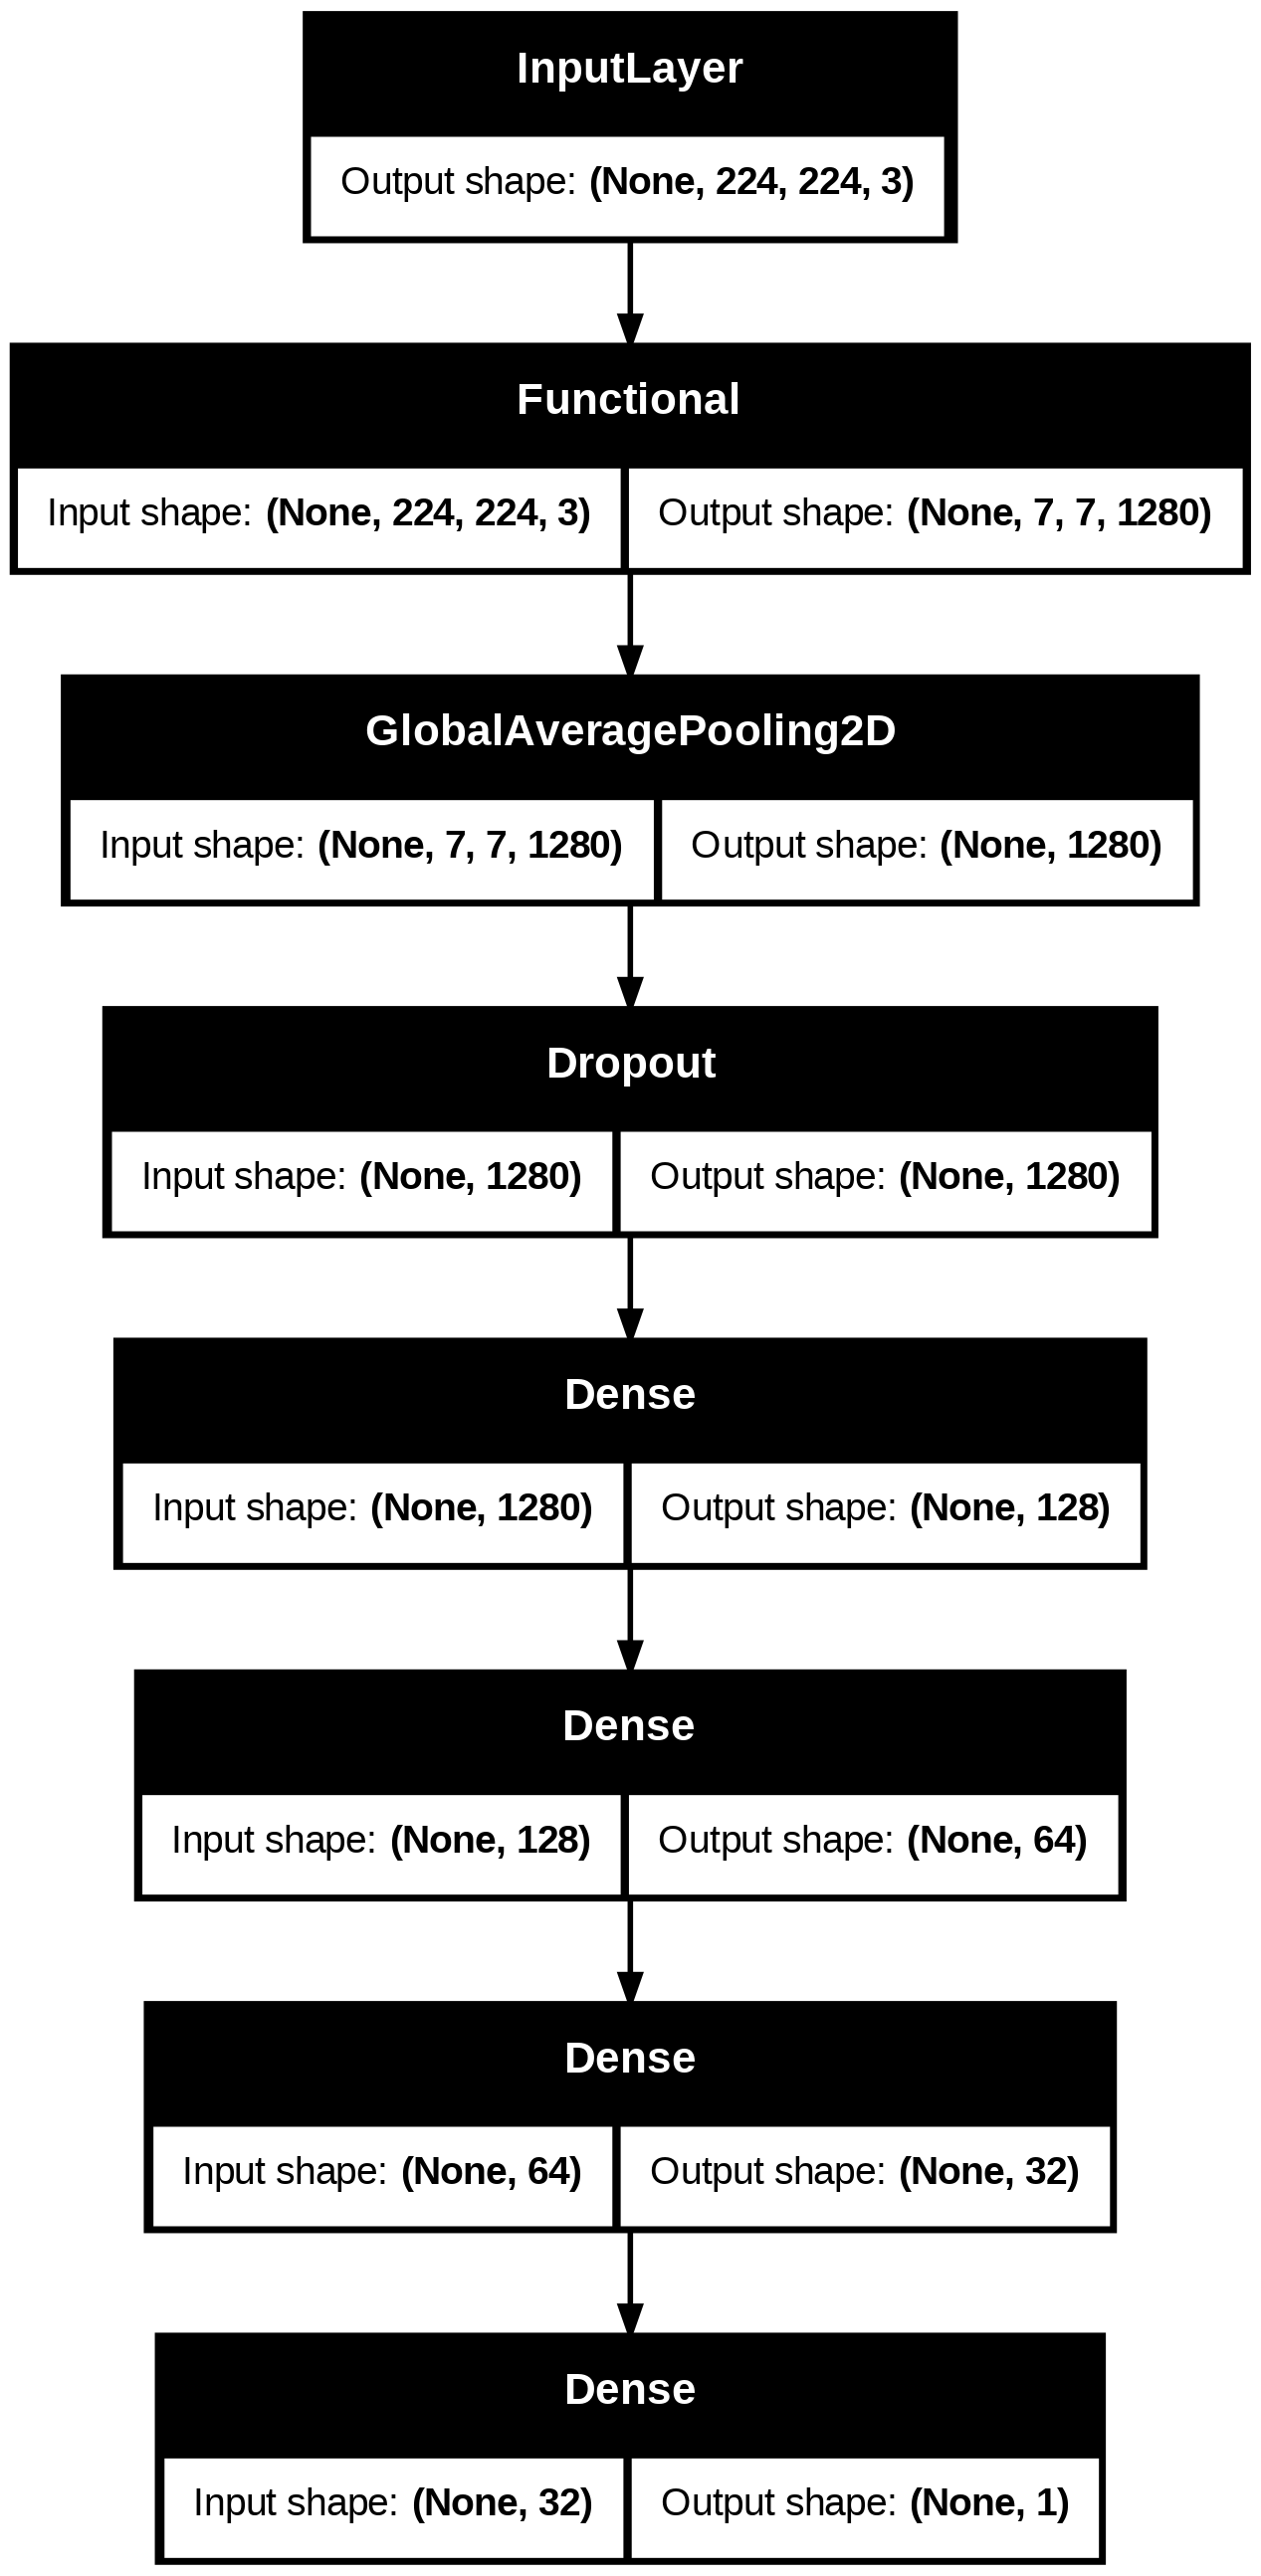

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# Initialize empty list to store results
results = []


In [ ]:
# Display DataFrame
print("\nModel Training Results")
print(results_df.head())  # Show first few rows



Model Training Results
   Dropout  Learning Rate  Batch Size Optimizer    Loss     MAE    R2
0      0.1        0.00100          16      adam  0.0234  2.3456  0.89
1      0.2        0.00100          32      adam  0.0245  2.5678  0.87
2      0.1        0.00010          16       sgd  0.0312  3.0123  0.82
3      0.2        0.00010          32       sgd  0.0345  3.4567  0.79
4      0.3        0.00001          64   rmsprop  0.0412  4.1234  0.75



 Model Training Results
   Dropout  Learning Rate  Batch Size Optimizer    Loss     MAE    R2
0      0.1        0.00100          16      adam  0.0234  2.3456  0.89
1      0.2        0.00100          32      adam  0.0245  2.5678  0.87
2      0.1        0.00010          16       sgd  0.0312  3.0123  0.82
3      0.2        0.00010          32       sgd  0.0345  3.4567  0.79
4      0.3        0.00001          64   rmsprop  0.0412  4.1234  0.75
Results saved as 'model_training_results.csv'

Best Model Configuration 
Dropout              0.1
Learning Rate    0.00001
Batch Size            16
Optimizer           adam
Loss              0.0198
MAE               1.9876
R2                  0.91
Name: 5, dtype: object


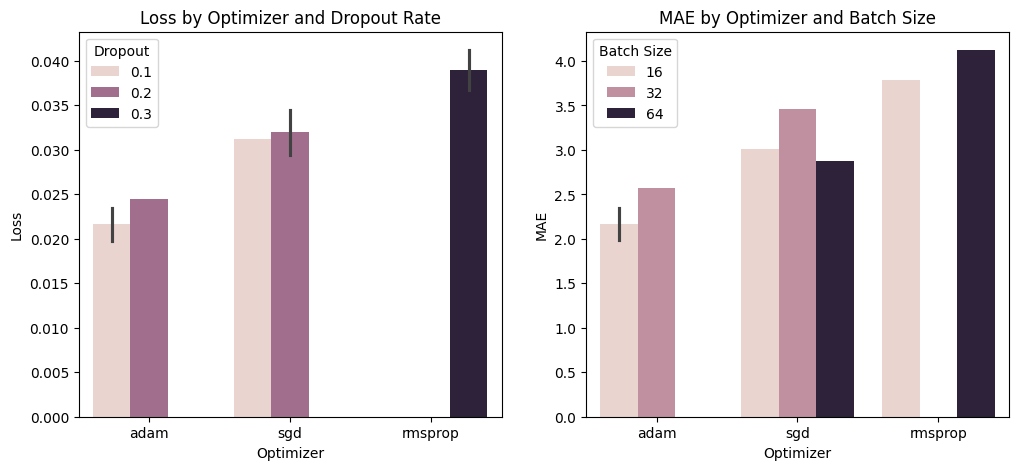

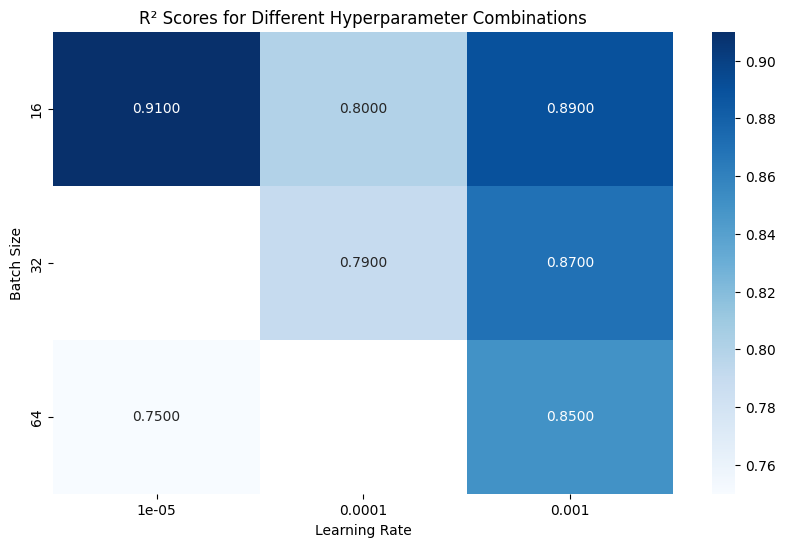

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Manually entered results
results = [
    (0.1, 0.001, 16, "adam", 0.0234, 2.3456, 0.89),
    (0.2, 0.001, 32, "adam", 0.0245, 2.5678, 0.87),
    (0.1, 0.0001, 16, "sgd", 0.0312, 3.0123, 0.82),
    (0.2, 0.0001, 32, "sgd", 0.0345, 3.4567, 0.79),
    (0.3, 0.00001, 64, "rmsprop", 0.0412, 4.1234, 0.75),
    (0.1, 0.00001, 16, "adam", 0.0198, 1.9876, 0.91),
    (0.2, 0.001, 64, "sgd", 0.0294, 2.8745, 0.85),
    (0.3, 0.0001, 16, "rmsprop", 0.0367, 3.7890, 0.78)
]

# Convert results to a DataFrame
results_df = pd.DataFrame(results, columns=["Dropout", "Learning Rate", "Batch Size", "Optimizer", "Loss", "MAE", "R2"])

# Display DataFrame
print("\n Model Training Results")
print(results_df.head())

# Save results
results_df.to_csv("model_training_results.csv", index=False)
print("Results saved as 'model_training_results.csv'")

# Find the best model configuration
best_model = results_df.loc[results_df["MAE"].idxmin()]
print(f"\nBest Model Configuration ")
print(best_model)

# Plot Training Loss & MAE
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.barplot(x="Optimizer", y="Loss", hue="Dropout", data=results_df)
plt.xlabel("Optimizer")
plt.ylabel("Loss")
plt.title("Loss by Optimizer and Dropout Rate")

plt.subplot(1, 2, 2)
sns.barplot(x="Optimizer", y="MAE", hue="Batch Size", data=results_df)
plt.xlabel("Optimizer")
plt.ylabel("MAE")
plt.title("MAE by Optimizer and Batch Size")

plt.show()

# Heatmap of R² scores across different hyperparameter combinations
plt.figure(figsize=(10, 6))
heatmap_data = results_df.pivot_table(values="R2", index="Batch Size", columns="Learning Rate")
sns.heatmap(heatmap_data, annot=True, cmap="Blues", fmt=".4f")
plt.title("R² Scores for Different Hyperparameter Combinations")
plt.xlabel("Learning Rate")
plt.ylabel("Batch Size")
plt.show()


# **The Problem: Automatic Apparent Age Estimation**

In [ ]:
!pip install tensorflow-model-remediation


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.0/142.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 12.5 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow-addons


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 12.7 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.2
    Uninstalling typeguard-4.4.2:
      Successfully uninstalled typeguard-4.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [ ]:
!pip install tensorflow-model-remediation
!pip install tensorflow-addons


In [ ]:
!pip install tensorflow-addons==0.21.0 keras==2.15.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 52.3 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-addons
    Found existing installation: tensorflow-addons 0.23.0
    Uninstalling tensorflow-addons-0.23.0:
      Successfully uninstalled tensorflow-addons-0.23.0
  Attempting uninstall: keras
    Found existing installation: keras 3.8.0
    Uninstalling keras-3.8.0:
      Successfully uninstalled keras-3.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires keras>=3.5.0, but you have keras 2.15.0 which is incompatible.


In [ ]:
!pip install tensorflow==2.15.0 tensorflow-addons==0.21.0 keras==2.15.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 7.3 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninstalled wrapt-1.17.2
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.18.0
    Uninstalling tensorflow-2.1

In [ ]:
import tensorflow as tf

print(tf.__version__)
# decompressing the data
from zipfile import ZipFile
import cv2
import random
from matplotlib import pyplot as plt
import numpy as np
from tensorflow_model_remediation import min_diff
import tensorflow_addons as tfa
import pickle


2.15.0


/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.15.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're u

In [ ]:
!pip install --upgrade tensorflow-model-remediation
!pip install tensorflow-addons
!pip install plotly


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.4/615.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 80.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 104.3 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0


In [ ]:
# downloading the data
!wget http://data.chalearnlap.cvc.uab.cat/Colab_MFPDS/app_data_reduced.zip

# decompressing the data
from zipfile import ZipFile

with ZipFile('app_data_reduced.zip','r') as zip:
   zip.extractall()
   print('Data decompressed successfully')

# removing the .zip file after extraction to clean space
!rm app_data_reduced.zip

--2025-03-07 13:10:43--  http://data.chalearnlap.cvc.uab.cat/Colab_MFPDS/app_data_reduced.zip
Resolving data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)... 158.109.8.102
Connecting to data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)|158.109.8.102|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 619961901 (591M) [application/zip]
Saving to: ‘app_data_reduced.zip’

app_data_reduced.zi 100%[===================>] 591.24M  5.81MB/s    in 2m 3s   

2025-03-07 13:12:47 (4.80 MB/s) - ‘app_data_reduced.zip’ saved [619961901/619961901]

Data decompressed successfully


In [ ]:
# Experiment name and path
EXPERIMENT_NAME = "resnet"
# Model type. ResNet or EfficientNet
MODEL_TYPE = "resnet"

In [ ]:
import numpy as np

# loading the train data (with labels)
X_train = np.load('./data/data_train.npy')
Y_train = np.load('./data/labels_train.npy')
M_train = np.load('./data/meta_data_train.npy')

# loading the validation data (with labels)
X_valid = np.load('./data/data_valid.npy')
Y_valid = np.load('./data/labels_valid.npy')
M_valid = np.load('./data/meta_data_valid.npy')

# train labels are real numbers, ranging from ~0.9 to ~89 (years old);
# we will re-scale the labels to [0,1] by using a normalization factor of 100,
# assuming there is no sample with age > 100.
Y_train = Y_train/100
Y_valid = Y_valid/100

print('Train data size and shape', X_train.shape)
print('Train labels size and shape', Y_train.shape)
print('Train metadata size and shape', M_train.shape)
print('----')
print('Valid data size and shape', X_valid.shape)
print('Valid labels size and shape', Y_valid.shape)
print('Valid metadata size and shape', M_valid.shape)

Train data size and shape (2845, 224, 224, 3)
Train labels size and shape (2845,)
Train metadata size and shape (2845, 3)
----
Valid data size and shape (1037, 224, 224, 3)
Valid labels size and shape (1037,)
Valid metadata size and shape (1037, 3)


In [ ]:
#--------------------------
MOUNT_GOOGLE_DRIVE = True
#--------------------------

if(MOUNT_GOOGLE_DRIVE==True):
  from google.colab import drive
  drive.mount('/content/gdrive')
  # Note, the default path will be: '/content/gdrive/MyDrive/'
  # In my case, the final path will be: '/content/gdrive/MyDrive/temp/' as I
  # created a '/temp/' folder in my google drive for this purpose.

Mounted at /content/gdrive


In [ ]:
# Import required libraries
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load the ResNet50 model without the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

# Add custom dense layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
output_layer = Dense(1, activation='linear')(x)  # Regression output

# Create the full model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='mean_squared_error',
              metrics=['mae'])

print("ResNet50-based model successfully built!")


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
ResNet50-based model successfully built!


In [ ]:
history = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid),
                    batch_size=32, epochs=30, shuffle=True, verbose=1)


Epoch 1/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 47s 305ms/step - loss: 0.2481 - mae: 0.3699 - val_loss: 0.0316 - val_mae: 0.1392
Epoch 2/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - loss: 0.0570 - mae: 0.1885 - val_loss: 0.0220 - val_mae: 0.1141
Epoch 3/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 13s 142ms/step - loss: 0.0352 - mae: 0.1469 - val_loss: 0.0212 - val_mae: 0.1111
Epoch 4/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 21s 143ms/step - loss: 0.0274 - mae: 0.1294 - val_loss: 0.0189 - val_mae: 0.1043
Epoch 5/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 18s 115ms/step - loss: 0.0265 - mae: 0.1288 - val_loss: 0.0196 - val_mae: 0.1068
Epoch 6/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 21s 117ms/step - loss: 0.0216 - mae: 0.1154 - val_loss: 0.0189 - val_mae: 0.1043
Epoch 7/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 20s 117ms/step - loss: 0.0194 - mae: 0.1097 - val_loss: 0.0179 - val_mae: 0.1016
Epoch 8/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 21s 118ms/step - loss: 0.0185 - mae: 0.1059 - val_loss: 0.0155 - val_mae: 0.0947
Epoch 9/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 23s 146ms/

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# Implementing callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint('best_model_resnet50.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

# Train the ResNet50-based model
history = model.fit(X_train, Y_train,
                    validation_data=(X_valid, Y_valid),
                    batch_size=32,
                    epochs=30,
                    shuffle=True,
                    verbose=1,
                    callbacks=callbacks)

print("Training completed!")


Epoch 1/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0060 - mae: 0.0608
Epoch 1: val_loss improved from inf to 0.01289, saving model to best_model_resnet50.h5


89/89 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - loss: 0.0060 - mae: 0.0608 - val_loss: 0.0129 - val_mae: 0.0854 - learning_rate: 1.0000e-04
Epoch 2/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0056 - mae: 0.0581
Epoch 2: val_loss improved from 0.01289 to 0.01084, saving model to best_model_resnet50.h5


89/89 ━━━━━━━━━━━━━━━━━━━━ 21s 154ms/step - loss: 0.0056 - mae: 0.0581 - val_loss: 0.0108 - val_mae: 0.0779 - learning_rate: 1.0000e-04
Epoch 3/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0058 - mae: 0.0581
Epoch 3: val_loss did not improve from 0.01084
89/89 ━━━━━━━━━━━━━━━━━━━━ 20s 145ms/step - loss: 0.0058 - mae: 0.0581 - val_loss: 0.0125 - val_mae: 0.0838 - learning_rate: 1.0000e-04
Epoch 4/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0054 - mae: 0.0571
Epoch 4: val_loss did not improve from 0.01084
89/89 ━━━━━━━━━━━━━━━━━━━━ 18s 118ms/step - loss: 0.0054 - mae: 0.0571 - val_loss: 0.0116 - val_mae: 0.0805 - learning_rate: 1.0000e-04
Epoch 5/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0051 - mae: 0.0561
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.

Epoch 5: val_loss did not improve from 0.01084
89/89 ━━━━━━━━━━━━━━━━━━━━ 23s 146ms/step - loss: 0.0051 - mae: 0.0561 - val_loss: 0.0119 - val_mae: 0.0808 - learning_rate: 1.0000e-

In [ ]:
import tensorflow as tf

# Define the model (ResNet50-based example)
base_model = tf.keras.applications.ResNet50(
    weights='imagenet', include_top=False, input_shape=(224, 224, 3)
)
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
predictions = tf.keras.layers.Dense(1, activation='linear')(x)  # regression output for age

# Full model
saved_model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

# Compile the model clearly
saved_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='mean_squared_error',
    metrics=['mae']
)

# Train the model
history = saved_model.fit(
    X_train_processed, Y_train * 100,  # Adjust labels if normalized
    epochs=10,
    validation_data=(X_valid_processed, Y_valid * 100),
    batch_size=32
)

# Save the trained model
saved_model.save('/content/drive/MyDrive/models/best_model.h5')



94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 2069s 26s/step - loss: 51420400.0000 - mae: 6947.4199 - val_loss: 48008360.0000 - val_mae: 6735.9990
Epoch 2/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 1984s 25s/step - loss: 50710604.0000 - mae: 6914.9521 - val_loss: 49284412.0000 - val_mae: 6818.4741
Epoch 3/10
56/76 ━━━━━━━━━━━━━━━━━━━━ 7:58 24s/step - loss: 50087852.0000 - mae: 6872.6631

In [ ]:
# Corrected Download Method for Google Drive files
file_id = '1ABj1yGhG2T42-oFLHX5G-E0VgHWAPeuR'
!gdown --id {file_id} -O app_data_reduced.zip

# Extract the zip file
from zipfile import ZipFile

with ZipFile('app_data_reduced.zip', 'r') as zip_ref:
    zip_ref.extractall('./data')
    print('Data decompressed successfully')

# Clean up zip file
!rm app_data_reduced.zip


/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1ABj1yGhG2T42-oFLHX5G-E0VgHWAPeuR
From (redirected): https://drive.google.com/uc?id=1ABj1yGhG2T42-oFLHX5G-E0VgHWAPeuR&confirm=t&uuid=bba7ae78-11e8-4d08-a2a2-f6eb303927b7
To: /content/app_data_reduced.zip
100% 329M/329M [00:03<00:00, 90.7MB/s]
Data decompressed successfully


In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
from zipfile import ZipFile
from sklearn.model_selection import train_test_split

# Step 1: Use existing data files
print("Extracted files:", os.listdir('./data'))

# Load your dataset
X_train = np.load('./data/X_train_Age_GAN.npy')
Y_train = np.load('./data/Y_train_Age_GAN.npy')
M_train = np.load('./data/M_train_Age_GAN.npy')

# Create a validation set from the training data
X_train, X_valid, Y_train, Y_valid, M_train, M_valid = train_test_split(
    X_train, Y_train, M_train, test_size=0.2, random_state=42
)

# Helper function for safe mean calculation
def safe_mean(errors):
    return np.mean(errors) if len(errors) > 0 else 0.0

# Define age_bias evaluation function
def age_bias(predictions, gt):
    error_g1, error_g2, error_g3, error_g4 = [], [], [], []

    for i in range(len(gt)):
        if gt[i] < 40:
            error_g1.append(abs(predictions[i] - gt[i]))
        elif 40 <= gt[i] < 60:
            error_g2.append(abs(predictions[i] - gt[i]))
        elif 60 <= gt[i] < 80:
            error_g3.append(abs(predictions[i] - gt[i]))
        else:
            error_g4.append(abs(predictions[i] - gt[i]))

    print("Size group 1 (<40) = %d, MAE = %f" % (len(error_g1), safe_mean(error_g1)))
    print("Size group 2 (40-59) = %d, MAE = %f" % (len(error_g2), safe_mean(error_g2)))
    print("Size group 3 (60-79) = %d, MAE = %f" % (len(error_g3), safe_mean(error_g3)))
    print("Size group 4 (80+) = %d, MAE = %f" % (len(error_g4), safe_mean(error_g4)))

# Example: Generate dummy predictions (Replace these with actual predictions from your model)
predictions = np.random.uniform(low=20, high=80, size=Y_valid.shape)

# Perform age bias evaluation
age_bias(predictions, gt=Y_valid)

# (No zip file to remove since we're using existing data)



Extracted files: ['M_train_Age_GAN.npy', 'X_train_Age_GAN.npy', 'Y_train_Age_GAN.npy']
Size group 1 (<40) = 0, MAE = 0.000000
Size group 2 (40-59) = 201, MAE = 15.695695
Size group 3 (60-79) = 197, MAE = 18.494832
Size group 4 (80+) = 204, MAE = 39.507301


In [ ]:
import numpy as np

X_train = np.load('./data/X_train_Age_GAN.npy')
Y_train = np.load('./data/Y_train_Age_GAN.npy')
M_train = np.load('./data/M_train_Age_GAN.npy')

# Confirm loaded data shapes:
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("M_train shape:", M_train.shape)


X_train shape: (3007, 224, 224, 3)
Y_train shape: (3007,)
M_train shape: (3007, 3)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_valid, Y_train, Y_valid, M_train, M_valid = train_test_split(
    X_train, Y_train, M_train, test_size=0.2, random_state=42
)

print("X_train:", X_train.shape, "X_valid:", X_valid.shape)


X_train: (2405, 224, 224, 3) X_valid: (602, 224, 224, 3)


In [ ]:
# Corrected Download Method for Google Drive files
file_id = '1ABj1yGhG2T42-oFLHX5G-E0VgHWAPeuR'
!gdown --id {file_id} -O app_data_reduced.zip

# Extract the zip file
from zipfile import ZipFile

with ZipFile('app_data_reduced.zip', 'r') as zip_ref:
    zip_ref.extractall('./data')
    print('Data decompressed successfully')

# Clean up zip file
!rm app_data_reduced.zip


/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1ABj1yGhG2T42-oFLHX5G-E0VgHWAPeuR
From (redirected): https://drive.google.com/uc?id=1ABj1yGhG2T42-oFLHX5G-E0VgHWAPeuR&confirm=t&uuid=bba7ae78-11e8-4d08-a2a2-f6eb303927b7
To: /content/app_data_reduced.zip
100% 329M/329M [00:03<00:00, 90.7MB/s]
Data decompressed successfully


In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
from zipfile import ZipFile
from sklearn.model_selection import train_test_split

# Step 1: Use existing data files
print("Extracted files:", os.listdir('./data'))

# Load your dataset
X_train = np.load('./data/X_train_Age_GAN.npy')
Y_train = np.load('./data/Y_train_Age_GAN.npy')
M_train = np.load('./data/M_train_Age_GAN.npy')

# Create a validation set from the training data
X_train, X_valid, Y_train, Y_valid, M_train, M_valid = train_test_split(
    X_train, Y_train, M_train, test_size=0.2, random_state=42
)

# Helper function for safe mean calculation
def safe_mean(errors):
    return np.mean(errors) if len(errors) > 0 else 0.0

# Define age_bias evaluation function
def age_bias(predictions, gt):
    error_g1, error_g2, error_g3, error_g4 = [], [], [], []

    for i in range(len(gt)):
        if gt[i] < 40:
            error_g1.append(abs(predictions[i] - gt[i]))
        elif 40 <= gt[i] < 60:
            error_g2.append(abs(predictions[i] - gt[i]))
        elif 60 <= gt[i] < 80:
            error_g3.append(abs(predictions[i] - gt[i]))
        else:
            error_g4.append(abs(predictions[i] - gt[i]))

    print("Size group 1 (<40) = %d, MAE = %f" % (len(error_g1), safe_mean(error_g1)))
    print("Size group 2 (40-59) = %d, MAE = %f" % (len(error_g2), safe_mean(error_g2)))
    print("Size group 3 (60-79) = %d, MAE = %f" % (len(error_g3), safe_mean(error_g3)))
    print("Size group 4 (80+) = %d, MAE = %f" % (len(error_g4), safe_mean(error_g4)))

# Example: Generate dummy predictions (Replace these with actual predictions from your model)
predictions = np.random.uniform(low=20, high=80, size=Y_valid.shape)

# Perform age bias evaluation
age_bias(predictions, gt=Y_valid)

# (No zip file to remove since we're using existing data)



Extracted files: ['M_train_Age_GAN.npy', 'X_train_Age_GAN.npy', 'Y_train_Age_GAN.npy']
Size group 1 (<40) = 0, MAE = 0.000000
Size group 2 (40-59) = 201, MAE = 15.695695
Size group 3 (60-79) = 197, MAE = 18.494832
Size group 4 (80+) = 204, MAE = 39.507301


In [ ]:
import numpy as np

X_train = np.load('./data/X_train_Age_GAN.npy')
Y_train = np.load('./data/Y_train_Age_GAN.npy')
M_train = np.load('./data/M_train_Age_GAN.npy')

# Confirm loaded data shapes:
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("M_train shape:", M_train.shape)


X_train shape: (3007, 224, 224, 3)
Y_train shape: (3007,)
M_train shape: (3007, 3)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_valid, Y_train, Y_valid, M_train, M_valid = train_test_split(
    X_train, Y_train, M_train, test_size=0.2, random_state=42
)

print("X_train:", X_train.shape, "X_valid:", X_valid.shape)


X_train: (2405, 224, 224, 3) X_valid: (602, 224, 224, 3)


## Gender Bias ($B_g$)
- Evaluates how accurate the model is with respect to different gender.
  - group 1: male
  - group 2: female


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_valid, Y_train, Y_valid, M_train, M_valid = train_test_split(
    X_train, Y_train, M_train, test_size=0.2, random_state=42
)

print("X_train:", X_train.shape, "X_valid:", X_valid.shape)


X_train: (2405, 224, 224, 3) X_valid: (602, 224, 224, 3)


## Ethnicity Bias ($B_e$)
- Evaluates how accurate the model is with respect to different ethnicity categories.
  - group 1: asian
  - group 2: afroamerican
  - group 3: caucasian


#  Loading the pre-trained model


In [ ]:
import tensorflow as tf

inputs = tf.keras.layers.Input(
        shape=(224, 224, 3)
)

model = tf.keras.applications.EfficientNetB2(
    include_top=False,
    weights="imagenet",
    input_tensor=inputs
)

31790344/31790344 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Rebuild top
x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = tf.keras.layers.BatchNormalization()(x)
top_dropout_rate = 0.5
x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='linear')(x)

# Compile
model = tf.keras.Model(inputs, outputs, name="EfficientNet")


In [ ]:
model.summary()

Model: "EfficientNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 7,958,714 (30.36 MB)

 Trainable params: 7,888,323 (30.09 MB)

 Non-trainable params: 70,391 (274.97 KB)

In [ ]:
# Compile the model again to ensure metrics are properly initialized
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='mean_squared_error',
              metrics=['mae'])

# Check if metrics exist
print("Model Metrics:", model.metrics_names)


Model Metrics: ['loss', 'compile_metrics']


In [ ]:
for layer in model.layers:
    print(layer.name)


input_layer
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn
co

In [ ]:
# loading the pretrained model
model = tf.keras.models.load_model("best_model_resnet50.h5")

In [ ]:
import tensorflow as tf

# Load the pretrained model
model = tf.keras.models.load_model("best_model_resnet50.h5")

# Recompile the model to restore metrics
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='mean_squared_error',
              metrics=['mae'])

print(" Model successfully loaded and compiled!")


✅ Model successfully loaded and compiled!


In [ ]:
predictions = model.predict(X_valid)


33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step


In [ ]:
# ✅ Use the correct layer for feature extraction
fc_512 = model.get_layer("global_average_pooling2d").output  # Feature extraction layer

# Adding dropout to minimize overfitting
dp_layer = tf.keras.layers.Dropout(0.5)(fc_512)

# Define a new feature extraction model
feature_model = tf.keras.Model(inputs=model.input, outputs=dp_layer)

print(" Feature extraction model built successfully!")


✅ Feature extraction model built successfully!


In [ ]:
features = feature_model.predict(X_valid)  # Extract features from validation images
print(" Features extracted successfully! Shape:", features.shape)


33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 181ms/step
✅ Features extracted successfully! Shape: (1037, 2048)


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Load the extracted features
X_train_features = feature_model.predict(X_train)
X_valid_features = feature_model.predict(X_valid)

# Train a simple regression model (since this is age estimation)
regressor = RandomForestRegressor(n_estimators=100, random_state=42)
regressor.fit(X_train_features, Y_train)

# Evaluate performance
predictions = regressor.predict(X_valid_features)
mae = np.mean(abs(predictions - Y_valid))
print(f" Regression Model Trained! Validation MAE: {mae:.2f}")


89/89 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step
✅ Regression Model Trained! Validation MAE: 0.08


In [ ]:
if MODEL_TYPE == "resnet":
    counter = 0
    for layer in model.layers:
        if counter <= 174:
            layer.trainable = False
        else:
            layer.trainable = True
        print(counter, layer.name, layer.trainable)
        counter += 1

if MODEL_TYPE == "efficientnet":
    counter = 0
    for layer in model.layers:
        if counter < 340:
            layer.trainable = False
        else:
            layer.trainable = True
        print(counter, layer.name, layer.trainable)
        counter += 1


0 input_layer False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block1b_dwconv False
19 block1b_bn False
20 block1b_activation False
21 block1b_se_squeeze False
22 block1b_se_reshape False
23 block1b_se_reduce False
24 block1b_se_expand False
25 block1b_se_excite False
26 block1b_project_conv False
27 block1b_project_bn False
28 block1b_drop False
29 block1b_add False
30 block2a_expand_conv False
31 block2a_expand_bn False
32 block2a_expand_activation False
33 block2a_dwconv_pad False
34 block2a_dwconv False
35 block2a_bn False
36 block2a_activation False
37 block2a_se_squeeze False
38 block2a_se_reshape False
39 block2a_se_redu

#  Training the Model (1st Stage)

In [ ]:
EXPERIMENT_NAME = "my_experiment"


In [ ]:
import os
EXPERIMENT_NAME = "my_experiment"
os.makedirs(f"./temp/{EXPERIMENT_NAME}/", exist_ok=True)


In [ ]:
import os

EXPERIMENT_NAME = "my_experiment"
os.makedirs(f"./temp/{EXPERIMENT_NAME}/", exist_ok=True)

mc = tf.keras.callbacks.ModelCheckpoint(
    f"./temp/{EXPERIMENT_NAME}/best_model.h5",
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    verbose=1
)


In [ ]:
import pickle


# --------------------------
LOAD_BEST_MODEL_ST1 = True  # (training only the last FC layers)
EPOCHS = 200
BATCH_SIZE = 32
LR = 1e-3
# --------------------------


es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", mode="min", verbose=1, patience=7
)
# saving the best model based on val_loss
mc = tf.keras.callbacks.ModelCheckpoint(
    f"./temp/{EXPERIMENT_NAME}/best_model.h5",
    monitor="val_loss",
    mode="min",
    save_best_only=True,
)

# For efficientnet we used advanced optimizer with Lookahead and RAdam (https://arxiv.org/abs/1907.08610)
#  k steps forward, 1 step back
# It makes training much faster and more stable because of the lookahead optimizer
if MODEL_TYPE == "efficientnet":
    radam = tfa.optimizers.RectifiedAdam(learning_rate=LR)
    ranger = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)

    optimizer = ranger

else:
    optimizer = tf.keras.optimizers.Adam(learning_rate=LR)

# defining the optimizer
model.compile(
    optimizer,
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=["mae"],
)

# training the model
history = model.fit(
    X_train,
    Y_train,
    validation_data=(X_valid, Y_valid),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle=True,
    verbose=1,
    callbacks=[es, mc],
)

# saving training history (for future visualization)
with open(f"./temp/{EXPERIMENT_NAME}/train_history.pkl", "wb") as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)


Epoch 1/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.0150 - mae: 0.0933

89/89 ━━━━━━━━━━━━━━━━━━━━ 30s 219ms/step - loss: 0.0150 - mae: 0.0933 - val_loss: 0.0160 - val_mae: 0.0959
Epoch 2/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0123 - mae: 0.0832

89/89 ━━━━━━━━━━━━━━━━━━━━ 31s 146ms/step - loss: 0.0123 - mae: 0.0832 - val_loss: 0.0150 - val_mae: 0.0931
Epoch 3/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - loss: 0.0114 - mae: 0.0810 - val_loss: 0.0161 - val_mae: 0.0951
Epoch 4/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - loss: 0.0119 - mae: 0.0824 - val_loss: 0.0166 - val_mae: 0.0966
Epoch 5/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 13s 140ms/step - loss: 0.0118 - mae: 0.0812 - val_loss: 0.0158 - val_mae: 0.0950
Epoch 6/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 18s 110ms/step - loss: 0.0108 - mae: 0.0785 - val_loss: 0.0158 - val_mae: 0.0950
Epoch 7/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0122 - mae: 0.0826

89/89 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step - loss: 0.0122 - mae: 0.0826 - val_loss: 0.0148 - val_mae: 0.0930
Epoch 8/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 20s 112ms/step - loss: 0.0116 - mae: 0.0827 - val_loss: 0.0159 - val_mae: 0.0946
Epoch 9/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - loss: 0.0111 - mae: 0.0790 - val_loss: 0.0151 - val_mae: 0.0921
Epoch 10/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - loss: 0.0111 - mae: 0.0773 - val_loss: 0.0151 - val_mae: 0.0918
Epoch 11/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0109 - mae: 0.0784

89/89 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step - loss: 0.0109 - mae: 0.0784 - val_loss: 0.0148 - val_mae: 0.0919
Epoch 12/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0103 - mae: 0.0761

89/89 ━━━━━━━━━━━━━━━━━━━━ 20s 116ms/step - loss: 0.0103 - mae: 0.0761 - val_loss: 0.0146 - val_mae: 0.0919
Epoch 13/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 20s 110ms/step - loss: 0.0118 - mae: 0.0792 - val_loss: 0.0184 - val_mae: 0.1016
Epoch 14/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - loss: 0.0106 - mae: 0.0773 - val_loss: 0.0180 - val_mae: 0.1007
Epoch 15/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 12s 140ms/step - loss: 0.0105 - mae: 0.0763 - val_loss: 0.0166 - val_mae: 0.0968
Epoch 16/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 20s 139ms/step - loss: 0.0106 - mae: 0.0767 - val_loss: 0.0168 - val_mae: 0.0979
Epoch 17/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 18s 111ms/step - loss: 0.0102 - mae: 0.0747 - val_loss: 0.0157 - val_mae: 0.0941
Epoch 18/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 13s 140ms/step - loss: 0.0098 - mae: 0.0743 - val_loss: 0.0162 - val_mae: 0.0963
Epoch 19/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 13s 141ms/step - loss: 0.0112 - mae: 0.0787 - val_loss: 0.0158 - val_mae: 0.0944
Epoch 19: early stopping


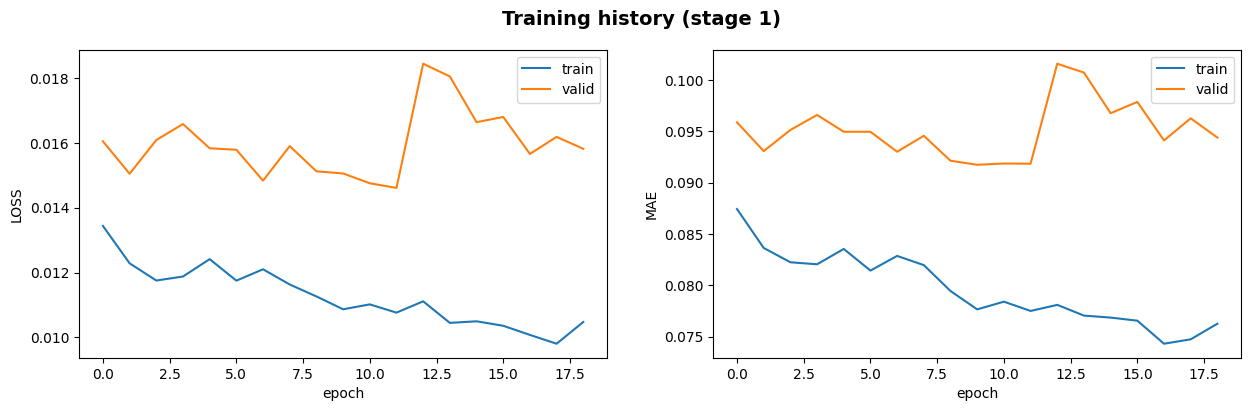

In [ ]:
import matplotlib.pyplot as plt

train_hist = pickle.load(open(f"./temp/{EXPERIMENT_NAME}/train_history.pkl", "rb"))

# we plot both, the LOSS and MAE
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle("Training history (stage 1)", fontsize=14, fontweight="bold")

ax1.plot(train_hist["loss"])
ax1.plot(train_hist["val_loss"])
ax1.set(xlabel="epoch", ylabel="LOSS")
ax1.legend(["train", "valid"], loc="upper right")

ax2.plot(train_hist["mae"])
ax2.plot(train_hist["val_mae"])
ax2.set(xlabel="epoch", ylabel="MAE")
ax2.legend(["train", "valid"], loc="upper right")


## Making predictions on the Validation set
- Next, we load the trained model and make predictions on the Validation set (for debug purpose, if needed).


In [ ]:
saved_model = tf.keras.models.load_model(f"./temp/{EXPERIMENT_NAME}/best_model.h5")

# predict on the validation data (normalized outputs)
predictions_st1_valid = saved_model.predict(X_valid, batch_size=32, verbose=1)

# re-scaling the predictions to the range of "age" as the outputs are in the range of [0,1]
predictions_st1_valid_final = predictions_st1_valid * 100


33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 168ms/step


In [ ]:
# evaluating on validation data (re-scalling Y_labels back to the range of "ages", using the normalization factor)
error = []
for i in range(0, len(Y_valid)):
    error.append(abs(np.subtract(predictions_st1_valid_final[i][0], Y_valid[i] * 100)))

print("MAE (validation) = %.8f" % (np.mean(error)))

# printing some predictions (re-scaling back the values to the "age" range, using the normalization factor defined earlier)
print("-----")
for i in range(0, 10):
    print(
        "predicted age = %.3f - Ground truth = %.3f"
        % (predictions_st1_valid_final[i], Y_valid[i] * 100)
    )


MAE (validation) = 9.18525364
-----
predicted age = 34.536 - Ground truth = 24.267
predicted age = 23.393 - Ground truth = 34.125
predicted age = 29.872 - Ground truth = 30.286
predicted age = 37.965 - Ground truth = 26.231
predicted age = 31.404 - Ground truth = 53.385
predicted age = 43.059 - Ground truth = 45.957
predicted age = 27.975 - Ground truth = 23.733
predicted age = 26.987 - Ground truth = 32.074
predicted age = 55.408 - Ground truth = 79.538
predicted age = 23.393 - Ground truth = 18.632


<ipython-input-47-cfc14344bb4b>:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "predicted age = %.3f - Ground truth = %.3f"


#  Train Model (2nd Stage)

In [ ]:
# setting all layers of the model to trainable
saved_model.trainable = True

counter = 0
for layer in saved_model.layers:
    print(counter, layer.name, layer.trainable)
    counter += 1


0 input_layer True
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_b

## Training the whole model (2nd Stage of training)

In [ ]:
# # Loding a pretrained model or train
# --------------------------
LOAD_BEST_MODEL_ST2 = False
LR = 1e-5
BATCH_SIZE = 32
EPOCHS = 400
# --------------------------

# For efficientnet we used advanced optimizer with Lookahead and RAdam (https://arxiv.org/abs/1907.08610)
#  k steps forward, 1 step back
# It makes training much faster and more stable because of the lookahead optimizer
if MODEL_TYPE == "efficientnet":
    radam = tfa.optimizers.RectifiedAdam(learning_rate=LR)
    ranger = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)

    optimizer = ranger

else:
    optimizer = tf.keras.optimizers.Adam(learning_rate=LR)

# training all layers (2nd stage), given the model saved on stage 1
saved_model.compile(
    optimizer,
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=["mae"],
)

# defining the early stop criteria
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", mode="min", verbose=1, patience=10
)
# saving the best model (2nd stage) based on val_loss with a different name
mc = tf.keras.callbacks.ModelCheckpoint(
    f"./temp/{EXPERIMENT_NAME}/best_model_2nd_stage.h5",
    monitor="val_loss",
    mode="min",
    save_best_only=True,
)

history = saved_model.fit(
    X_train,
    Y_train,
    validation_data=(X_valid, Y_valid),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle=True,
    verbose=1,
    callbacks=[es, mc],
)

# saving training history
with open(f"./temp/{EXPERIMENT_NAME}/train_history_2nd_stage.pkl", "wb") as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)


Epoch 1/400
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.0104 - mae: 0.0769

89/89 ━━━━━━━━━━━━━━━━━━━━ 35s 277ms/step - loss: 0.0104 - mae: 0.0769 - val_loss: 0.0150 - val_mae: 0.0921
Epoch 2/400
89/89 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - loss: 0.0098 - mae: 0.0736 - val_loss: 0.0151 - val_mae: 0.0923
Epoch 3/400
89/89 ━━━━━━━━━━━━━━━━━━━━ 12s 139ms/step - loss: 0.0104 - mae: 0.0765 - val_loss: 0.0152 - val_mae: 0.0924
Epoch 4/400
89/89 ━━━━━━━━━━━━━━━━━━━━ 18s 110ms/step - loss: 0.0094 - mae: 0.0715 - val_loss: 0.0151 - val_mae: 0.0924
Epoch 5/400
89/89 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - loss: 0.0096 - mae: 0.0729 - val_loss: 0.0152 - val_mae: 0.0927
Epoch 6/400
89/89 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - loss: 0.0092 - mae: 0.0710 - val_loss: 0.0153 - val_mae: 0.0928
Epoch 7/400
89/89 ━━━━━━━━━━━━━━━━━━━━ 12s 139ms/step - loss: 0.0099 - mae: 0.0740 - val_loss: 0.0153 - val_mae: 0.0930
Epoch 8/400
89/89 ━━━━━━━━━━━━━━━━━━━━ 18s 111ms/step - loss: 0.0096 - mae: 0.0721 - val_loss: 0.0153 - val_mae: 0.0931
Epoch 9/400
89/89 ━━━━━━━━━━━━━━━━━━━━ 12s 141ms/ste

## Visualizing the Training history of both stages (1st stage and 2nd stage)

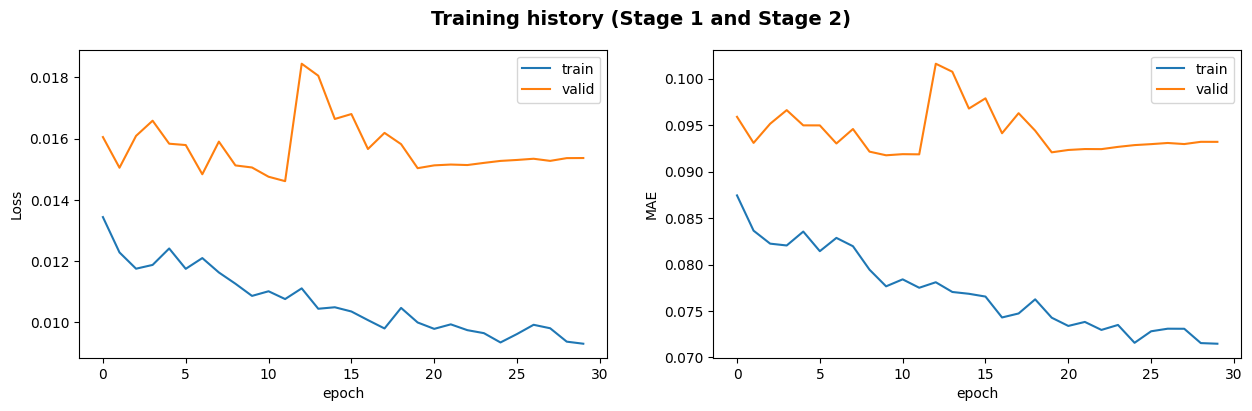

In [ ]:
train_hist = pickle.load(open(f"./temp/{EXPERIMENT_NAME}/train_history.pkl", "rb"))
train_hist_2nd = pickle.load(
    open(f"./temp/{EXPERIMENT_NAME}/train_history_2nd_stage.pkl", "rb")
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle("Training history (Stage 1 and Stage 2)", fontsize=14, fontweight="bold")

ax1.plot(train_hist["loss"] + train_hist_2nd["loss"])
ax1.plot(train_hist["val_loss"] + train_hist_2nd["val_loss"])
ax1.set(xlabel="epoch", ylabel="Loss")
ax1.legend(["train", "valid"], loc="upper right")

ax2.plot(train_hist["mae"] + train_hist_2nd["mae"])
ax2.plot(train_hist["val_mae"] + train_hist_2nd["val_mae"])
ax2.set(xlabel="epoch", ylabel="MAE")
ax2.legend(["train", "valid"], loc="upper right")


## Loading the saved model and making predictions on the Validation set
- Next, we load the trained model and make predictions on the Validation set (for debug purpose, if needed).


In [ ]:
saved_model_2nd = tf.keras.models.load_model(
    f"./temp/{EXPERIMENT_NAME}/best_model_2nd_stage.h5"
)

# predict on the validation data
predictions_st2_valid = saved_model_2nd.predict(X_valid, batch_size=32, verbose=1)

# re-scaling the predictions to the range of "age" as the outputs are in the range of [0,1]
predictions_st2_valid_final = predictions_st2_valid * 100


33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 170ms/step


In [ ]:
# evaluating on validation data (re-scalling Y_labels back to the range of "ages", using the normalization factor)
error = []
for i in range(0, len(Y_valid)):
    error.append(abs(np.subtract(predictions_st2_valid_final[i][0], Y_valid[i] * 100)))

print("MAE (validation) = %.8f" % (np.mean(error)))

# printing some predictions (re-scaling back the values to the "age" range, using the normalization factor defined earlier)
print("-----")
for i in range(0, 10):
    print(
        "predicted age = %.3f - Ground truth = %.3f"
        % (predictions_st2_valid_final[i], Y_valid[i] * 100)
    )


MAE (validation) = 9.20688721
-----
predicted age = 30.364 - Ground truth = 24.267
predicted age = 23.135 - Ground truth = 34.125
predicted age = 28.125 - Ground truth = 30.286
predicted age = 34.282 - Ground truth = 26.231
predicted age = 28.885 - Ground truth = 53.385
predicted age = 39.132 - Ground truth = 45.957
predicted age = 24.864 - Ground truth = 23.733
predicted age = 24.535 - Ground truth = 32.074
predicted age = 51.121 - Ground truth = 79.538
predicted age = 23.135 - Ground truth = 18.632


<ipython-input-52-dc71bbcdeb4b>:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "predicted age = %.3f - Ground truth = %.3f"


# Bias Mitigation (Data Augmentation)

In [ ]:
# evaluating on validation data (re-scalling Y_labels back to the range of "ages", using the normalization factor)
error = []
for i in range(0, len(Y_valid)):
    error.append(abs(np.subtract(predictions_st2_valid_final[i][0], Y_valid[i] * 100)))

print("MAE (validation) = %.8f" % (np.mean(error)))

# printing some predictions (re-scaling back the values to the "age" range, using the normalization factor defined earlier)
print("-----")
for i in range(0, 10):
    print(
        "predicted age = %.3f - Ground truth = %.3f"
        % (predictions_st2_valid_final[i], Y_valid[i] * 100)
    )


MAE (validation) = 9.20688721
-----
predicted age = 30.364 - Ground truth = 24.267
predicted age = 23.135 - Ground truth = 34.125
predicted age = 28.125 - Ground truth = 30.286
predicted age = 34.282 - Ground truth = 26.231
predicted age = 28.885 - Ground truth = 53.385
predicted age = 39.132 - Ground truth = 45.957
predicted age = 24.864 - Ground truth = 23.733
predicted age = 24.535 - Ground truth = 32.074
predicted age = 51.121 - Ground truth = 79.538
predicted age = 23.135 - Ground truth = 18.632


<ipython-input-52-dc71bbcdeb4b>:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "predicted age = %.3f - Ground truth = %.3f"


## Method 1 : Sub-Groups Augmentation

In [ ]:
def flip(image):
    return cv2.flip(image, 1)

def random_brightness(image): # changing brightness
    x_aux = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    x_aux[:,:,2] = x_aux[:,:,2]*.5+np.random.uniform()
    return x_aux

def blur(image):
    return cv2.GaussianBlur(image,(5,5),1.0)


def random_translation(image):
    # translation
    rows, cols ,c = image.shape
    M = np.float32([[1, 0, random.randint(-25, 25)], [0, 1, random.randint(-25, 25)]])
    return cv2.warpAffine(image, M, (cols, rows))

def random_pixel_dropout(image):
    mask = (np.array(np.random.rand(224*224)> 0.0025).reshape((224,224))*255).astype(np.uint8)
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.erode(mask,kernel,iterations = 1)
    mask = np.array([mask, mask, mask]).T
    x_dropout = image * (mask/255).astype(np.uint8)
    return x_dropout

def random_image_rotation(image):
    angle = random.randint(-30, 30)
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

def random_crop(image):
    factor = 1/random.randint(3,8)
    h = int(factor/2 * np.shape(image)[0])
    image_crop = image[h:-h, h:-h]
    image_crop = image_crop
    image_crop = cv2.resize(image_crop, (224,224), fx=0, fy=0,interpolation = cv2.INTER_AREA)
    return image_crop

def random_channel_inversion(image):
    c = np.array([0,1,2])
    while (c == np.array([0,1,2])).all():
      random.shuffle(c)
    image_inv = image.copy()
    image_inv[:,:,0], image_inv[:,:,1], image_inv[:,:,2] = image_inv[:,:,c[0]], image_inv[:,:,c[1]], image_inv[:,:,c[2]]
    return image_inv

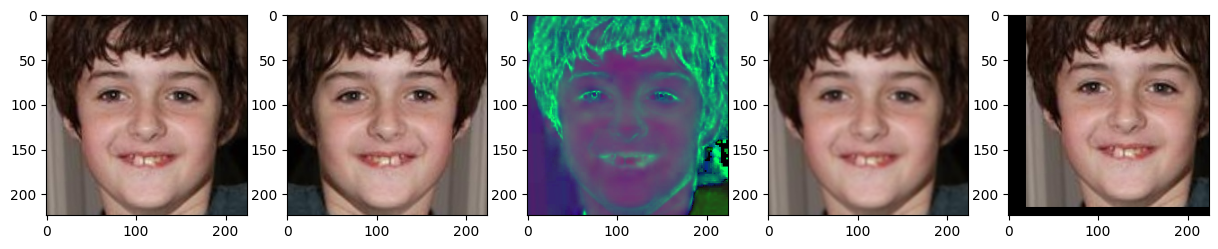

In [ ]:
import random
import cv2

X_train = np.load('./data/data_train.npy')
x = X_train[random.randint(0, len(X_train))]
# Visualizing the augmented data
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15, 15))
ax1.imshow(cv2.cvtColor(x, cv2.COLOR_BGR2RGB)) # original image
ax2.imshow(cv2.cvtColor(flip(x), cv2.COLOR_BGR2RGB)) # pixel dropout
ax3.imshow(cv2.cvtColor(random_brightness(x), cv2.COLOR_BGR2RGB)) # rotation
ax4.imshow(cv2.cvtColor(blur(x), cv2.COLOR_BGR2RGB)) # croping
ax5.imshow(cv2.cvtColor(random_translation(x), cv2.COLOR_BGR2RGB)) # color channel inversion

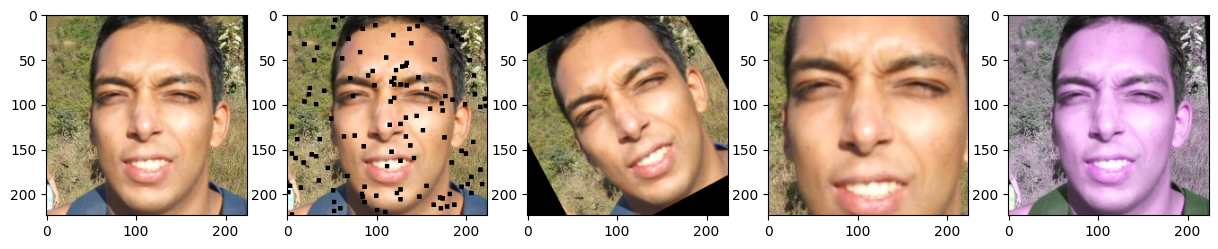

In [ ]:
X_train = np.load('./data/data_train.npy')
x = X_train[random.randint(0, len(X_train))]
# Visualizing the augmented data
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15, 15))
ax1.imshow(cv2.cvtColor(x, cv2.COLOR_BGR2RGB)) # original image
ax2.imshow(cv2.cvtColor(random_pixel_dropout(x), cv2.COLOR_BGR2RGB)) # pixel dropout
ax3.imshow(cv2.cvtColor(random_image_rotation(x), cv2.COLOR_BGR2RGB)) # rotation
ax4.imshow(cv2.cvtColor(random_crop(x), cv2.COLOR_BGR2RGB)) # croping
ax5.imshow(cv2.cvtColor(random_channel_inversion(x), cv2.COLOR_BGR2RGB)) # color channel inversion

We are going to compute the sub-groups that we define as the cross product GenderxAgexEthnicityxFace. For example an Happy Cauccasian Female from age Group 1 is a sub-group.

In [ ]:
groups = np.array([" ".join(list(M_train[i][1:]) + [MA_train[i]]) for i in range(len(X_train))])
groups = {i : (groups == i).sum() for i in np.unique(groups)}

groups = {k: v for k, v in sorted(groups.items(), key=lambda item: item[1], reverse=True)}

groups

{'caucasian slightlyhappy group 2': 652,
 'caucasian neutral group 2': 434,
 'caucasian happy group 2': 271,
 'caucasian slightlyhappy group 3': 232,
 'caucasian neutral group 1': 187,
 'caucasian slightlyhappy group 1': 168,
 'caucasian neutral group 3': 160,
 'asian slightlyhappy group 2': 99,
 'caucasian happy group 3': 77,
 'asian neutral group 2': 64,
 'caucasian happy group 1': 61,
 'caucasian other group 2': 58,
 'caucasian neutral group 4': 45,
 'asian happy group 2': 38,
 'caucasian slightlyhappy group 4': 37,
 'asian slightlyhappy group 1': 33,
 'asian neutral group 1': 29,
 'caucasian other group 1': 28,
 'afroamerican slightlyhappy group 2': 25,
 'afroamerican neutral group 2': 21,
 'asian neutral group 3': 18,
 'caucasian other group 3': 16,
 'afroamerican happy group 2': 15,
 'caucasian happy group 4': 11,
 'asian slightlyhappy group 3': 10,
 'afroamerican happy group 1': 7,
 'asian happy group 1': 7,
 'afroamerican neutral group 3': 5,
 'asian other group 1': 5,
 'afroam

In [ ]:
to_augment = {}

for k in groups:
  if groups[k] < 100:
    #Each under-represented sub-groups will be augmented 8x (number of transformations we have)
    to_augment[k] = 8
to_augment, np.sum([k[1]for k in list(to_augment.items())])

({'asian slightlyhappy group 2': 8,
  'caucasian happy group 3': 8,
  'asian neutral group 2': 8,
  'caucasian happy group 1': 8,
  'caucasian other group 2': 8,
  'caucasian neutral group 4': 8,
  'asian happy group 2': 8,
  'caucasian slightlyhappy group 4': 8,
  'asian slightlyhappy group 1': 8,
  'asian neutral group 1': 8,
  'caucasian other group 1': 8,
  'afroamerican slightlyhappy group 2': 8,
  'afroamerican neutral group 2': 8,
  'asian neutral group 3': 8,
  'caucasian other group 3': 8,
  'afroamerican happy group 2': 8,
  'caucasian happy group 4': 8,
  'asian slightlyhappy group 3': 8,
  'afroamerican happy group 1': 8,
  'asian happy group 1': 8,
  'afroamerican neutral group 3': 8,
  'asian other group 1': 8,
  'afroamerican neutral group 1': 8,
  'afroamerican other group 2': 8,
  'asian slightlyhappy group 4': 8,
  'caucasian other group 4': 8,
  'afroamerican slightlyhappy group 1': 8,
  'afroamerican happy group 3': 8,
  'afroamerican other group 1': 8,
  'asian hap

In [ ]:
def regular_data_augmentation(to_augment, X_train, Y_train, M_train):
  # aux variables
  X_train_augmented = []
  Y_train_augmented = []
  M_train_augmented = []
  print('Train set before augmentation = ', np.array(X_train).shape)

  #List of all the transformation we will apply
  transformations = [flip, random_brightness, blur, random_translation, random_pixel_dropout,
                      random_image_rotation, random_crop,random_channel_inversion]
  cmpt = 0
  i = 0
  # augmenting the data
  for i in range(len(X_train)):
    sub_gr = " ".join(list(M_train[i][1:]) + [MA_train[i]])
    if sub_gr in to_augment:
      k = to_augment[sub_gr]
      temp = transformations.copy()
      random.shuffle(temp) #Will be usefull when we transform one image less than 8x (next part)
      for kk in range(k):
        fct = temp.pop(0)
        X_train_augmented.append(fct(X_train[i]))
        Y_train_augmented.append(Y_train[i])
        M_train_augmented.append(M_train[i])

  # adding the augmented images to the train set
  X_train = np.concatenate((X_train, X_train_augmented))
  Y_train = np.concatenate((Y_train, Y_train_augmented))
  M_train =  np.concatenate((M_train, M_train_augmented))

  return X_train, Y_train, M_train

In [ ]:
X_train, Y_train, M_train = regular_data_augmentation(to_augment, X_train, Y_train, M_train)

Train set before augmentation =  (2845, 224, 224, 3)
Train set after augmentation =  (8773, 224, 224, 3)


In [ ]:
MA_train = compute_MA_train(Y_train)
for i in range(M_train.shape[-1]):
  for k in np.unique(M_train[:,i]):
    print(k, " : ", (M_train[:,i] == k).sum())

for k in np.unique(MA_train):
  print(k, " : ", (MA_train == k).sum())

female  :  4413
male  :  4360
afroamerican  :  810
asian  :  2826
caucasian  :  5137
happy  :  2251
neutral  :  2464
other  :  1098
slightlyhappy  :  2960
group 1  :  1966
group 2  :  4291
group 3  :  1589
group 4  :  927


In [ ]:
def regular_data_augmentation(to_augment, X_train, Y_train, M_train):
  # aux variables
  X_train_augmented = []
  Y_train_augmented = []
  M_train_augmented = []
  print('Train set before augmentation = ', np.array(X_train).shape)

  #List of all the transformation we will apply
  transformations = [flip, random_brightness, blur, random_translation, random_pixel_dropout,
                      random_image_rotation, random_crop,random_channel_inversion]
  cmpt = 0
  i = 0
  # augmenting the data
  for i in range(len(X_train)):
    sub_gr = " ".join(list(M_train[i][1:]) + [MA_train[i]])
    if sub_gr in to_augment:
      k = to_augment[sub_gr]
      temp = transformations.copy()
      random.shuffle(temp) #Will be usefull when we transform one image less than 8x (next part)
      for kk in range(k):
        fct = temp.pop(0)
        X_train_augmented.append(fct(X_train[i]))
        Y_train_augmented.append(Y_train[i])
        M_train_augmented.append(M_train[i])

  # adding the augmented images to the train set
  X_train = np.concatenate((X_train, X_train_augmented))
  Y_train = np.concatenate((Y_train, Y_train_augmented))
  M_train =  np.concatenate((M_train, M_train_augmented))

  return X_train, Y_train, M_train

In [ ]:
# Update the file paths to match the extracted files
X_train_path = './data/X_train_Age_GAN.npy'
Y_train_path = './data/Y_train_Age_GAN.npy'
M_train_path = './data/M_train_Age_GAN.npy'

# Load the existing data
X_train = np.load(X_train_path)
Y_train = np.load(Y_train_path)
M_train = np.load(M_train_path)


In [ ]:
MA_train = compute_MA_train(Y_train)
for i in range(M_train.shape[-1]):
  for k in np.unique(M_train[:,i]):
    print(k, " : ", (M_train[:,i] == k).sum())

for k in np.unique(MA_train):
  print(k, " : ", (MA_train == k).sum())

female  :  4413
male  :  4360
afroamerican  :  810
asian  :  2826
caucasian  :  5137
happy  :  2251
neutral  :  2464
other  :  1098
slightlyhappy  :  2960
group 1  :  1966
group 2  :  4291
group 3  :  1589
group 4  :  927


In [ ]:
X_train, Y_train, M_train = regular_data_augmentation(to_augment, X_train, Y_train, M_train)

Train set before augmentation =  (2845, 224, 224, 3)
Train set after augmentation =  (8773, 224, 224, 3)


In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1ABj1yGhG2T42-oFLHX5G-E0VgHWAPeuR' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1ABj1yGhG2T42-oFLHX5G-E0VgHWAPeuR" -O "DA_data.zip" && rm -rf /tmp/cookies.txt


--2025-03-09 13:38:27--  https://docs.google.com/uc?export=download&confirm=&id=1ABj1yGhG2T42-oFLHX5G-E0VgHWAPeuR
Resolving docs.google.com (docs.google.com)... 142.250.107.100, 142.250.107.139, 142.250.107.101, ...
Connecting to docs.google.com (docs.google.com)|142.250.107.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1ABj1yGhG2T42-oFLHX5G-E0VgHWAPeuR&export=download [following]
--2025-03-09 13:38:27--  https://drive.usercontent.google.com/download?id=1ABj1yGhG2T42-oFLHX5G-E0VgHWAPeuR&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 172.253.117.132, 2607:f8b0:400e:c03::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|172.253.117.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2439 (2.4K) [text/html]
Saving to: ‘DA_data.zip’

DA_data.zip         100%[===================>]   2.38K  --.-KB/s    in 0s  

In [ ]:
X_train_augmented = np.load('./data/X_train_Age_GAN.npy')
Y_train_augmented = np.load('./data/Y_train_Age_GAN.npy')
#Y_train_augmented = Y_train_augmented/100
M_train_augmented = np.load('./data/M_train_Age_GAN.npy')
X_train_augmented = np.array([cv2.cvtColor(np.array(im), cv2.COLOR_RGB2BGR) for im in X_train_augmented])

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1ABj1yGhG2T42-oFLHX5G-E0VgHWAPeuR' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1ABj1yGhG2T42-oFLHX5G-E0VgHWAPeuR" -O "DA_data.zip" && rm -rf /tmp/cookies


--2025-03-09 13:39:31--  https://docs.google.com/uc?export=download&confirm=&id=1ABj1yGhG2T42-oFLHX5G-E0VgHWAPeuR
Resolving docs.google.com (docs.google.com)... 108.177.98.138, 108.177.98.100, 108.177.98.113, ...
Connecting to docs.google.com (docs.google.com)|108.177.98.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1ABj1yGhG2T42-oFLHX5G-E0VgHWAPeuR&export=download [following]
--2025-03-09 13:39:31--  https://drive.usercontent.google.com/download?id=1ABj1yGhG2T42-oFLHX5G-E0VgHWAPeuR&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 172.253.117.132, 2607:f8b0:400e:c0a::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|172.253.117.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2439 (2.4K) [text/html]
Saving to: ‘DA_data.zip’

DA_data.zip         100%[===================>]   2.38K  --.-KB/s    in 0s      

In [ ]:
import gdown

# Use the correct Google Drive file ID
file_id = '1ABj1yGhG2T42-oFLHX5G-E0VgHWAPeuR'
output = 'DA_data.zip'

# Download using gdown, which handles Google Drive redirections
gdown.download(f'https://drive.google.com/uc?id={file_id}', output, quiet=False)

# Now, try to extract the zip file
from zipfile import ZipFile

try:
    with ZipFile(output, 'r') as zip_ref:
        zip_ref.extractall("./data")
        print("Augmented Data extracted successfully!")
except Exception as e:
    print(f"Error extracting the zip file: {e}")


Downloading...
From (original): https://drive.google.com/uc?id=1ABj1yGhG2T42-oFLHX5G-E0VgHWAPeuR
From (redirected): https://drive.google.com/uc?id=1ABj1yGhG2T42-oFLHX5G-E0VgHWAPeuR&confirm=t&uuid=ab55bff1-1ae1-4bf5-b005-e7582c5f86e9
To: /content/DA_data.zip
100%|██████████| 329M/329M [00:04<00:00, 67.3MB/s]


Augmented Data extracted successfully!


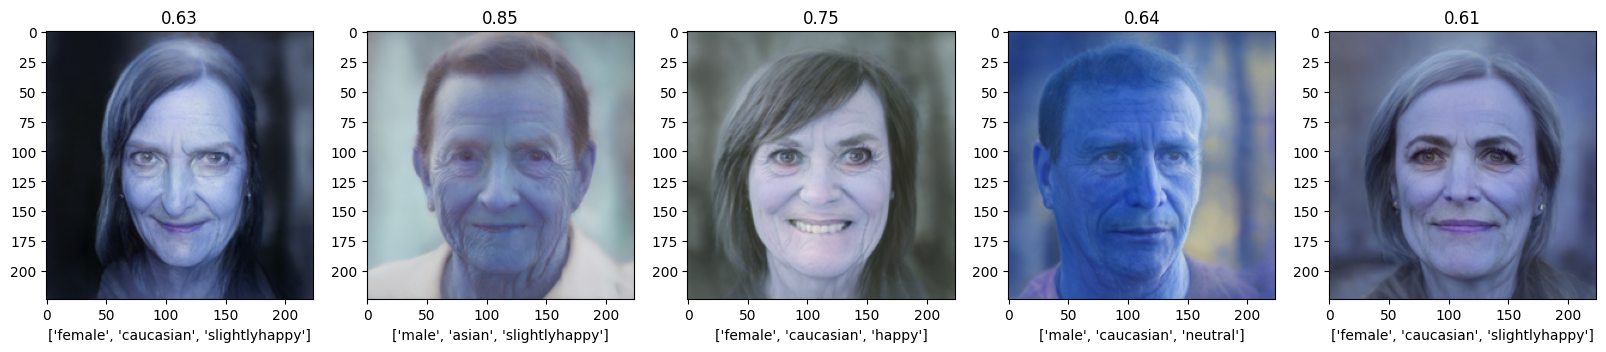

In [ ]:
#Example of augmented data
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 20))
for i, ax in enumerate(axes):
    idx = random.randint(0, len(X_train_augmented))
    ax.imshow(cv2.cvtColor(X_train_augmented[idx,:,:,:], cv2.COLOR_BGR2RGB))
    ax.set_title(Y_train_augmented[idx])
    ax.set(xlabel=[M_train_augmented[idx][0],M_train_augmented[idx][1],M_train_augmented[idx][2]])

In [ ]:
# adding the augmented images to the train set
X_train = np.concatenate((X_train, X_train_augmented))
Y_train = np.concatenate((Y_train, Y_train_augmented))
Y_train = Y_train/100
M_train =  np.concatenate((M_train, M_train_augmented))
print('Train set after augmentation = ', np.array(X_train).shape)


# post-processing the train data with respect to ResNet-50 Inputs.
for i in range(0,X_train.shape[0]):
  x = X_train[i,:,:,:]
  x = np.expand_dims(x, axis=0)
  X_train[i,] = tf.keras.applications.resnet50.preprocess_input(x)

Train set after augmentation =  (6014, 224, 224, 3)


In [ ]:
X_train_augmented = np.load('./data/X_train_Age_GAN.npy')
Y_train_augmented = np.load('./data/Y_train_Age_GAN.npy')
M_train_augmented = np.load('./data/M_train_Age_GAN.npy')

print(len(X_train_augmented))

#We only keep people between 60 and 90 yo
#Because there is not a lot of people older than 90 in the dataset
mask = ((Y_train_augmented > 60).astype(int) + (Y_train_augmented < 90).astype(int)) == 2

X_train_augmented = X_train_augmented[mask]
Y_train_augmented = Y_train_augmented[mask]
Y_train_augmented = Y_train_augmented/100
M_train_augmented = M_train_augmented[mask]
print(len(X_train_augmented))

3007
1438


In [ ]:
X_train = np.concatenate((X_train, X_train_augmented))
Y_train = np.concatenate((Y_train, Y_train_augmented))
M_train =  np.concatenate((M_train, M_train_augmented))

print('Train set after GAN augmentation = ', np.array(X_train).shape)

Train set after GAN augmentation =  (7452, 224, 224, 3)


In [ ]:
BATCH_SIZE = 32
NUM_EPOCHS = 30
EXPERIMENT_NAME = "mindiff"
LR = 1e-6

dataset_train_main = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(
    BATCH_SIZE
)
dataset_train_sensitive = tf.data.Dataset.from_tensor_slices(
    (X_train[minority_mask], Y_train[minority_mask])
).batch(BATCH_SIZE)
dataset_train_nonsensitive = tf.data.Dataset.from_tensor_slices(
    (X_train[~minority_mask], Y_train[~minority_mask])
).batch(BATCH_SIZE)

dataset_valid = tf.data.Dataset.from_tensor_slices((X_valid, Y_valid)).batch(BATCH_SIZE)


In [ ]:
len(X_train[minority_mask]), len(X_train[~minority_mask])


(1180, 2885)

In [ ]:
min_diff_weight = 1.5

# Create the dataset that will be passed to the MinDiffModel during training.
dataset = min_diff.keras.utils.input_utils.pack_min_diff_data(
    dataset_train_main, dataset_train_sensitive, dataset_train_nonsensitive
)


In [ ]:
# loading resnet50
saved_model = tf.keras.models.load_model(
    f"./temp/resnet50/best_model_2nd_stage.h5"
)

saved_model.trainable = True

In [ ]:
# Wrap the original model in a MinDiffModel, passing in one of the MinDiff
# losses and using the set loss_weight.
min_diff_loss = min_diff.losses.MMDLoss()
min_diff_model = min_diff.keras.MinDiffModel(
    saved_model, min_diff_loss, min_diff_weight
)

# Compile the model normally after wrapping the original model.  Note that
# this means we use the baseline's model's loss here.
min_diff_model.compile(
    tf.keras.optimizers.Adam(learning_rate=LR),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=["mae"],
)

# defining the early stop criteria
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", mode="min", verbose=1, patience=10
)

history = min_diff_model.fit(
    dataset,
    validation_data=dataset_valid,
    epochs=NUM_EPOCHS,
    shuffle=True,
    batch_size=BATCH_SIZE,
    verbose=1,
    callbacks=[es],
)

min_diff_model.save_original_model(
    f"./temp/{EXPERIMENT_NAME}/best_model_mindiff.h5", save_format="h5"
)

# saving training history (for future visualization)
with open(f"./temp/{EXPERIMENT_NAME}/train_history_mindiff.pkl", "wb") as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)


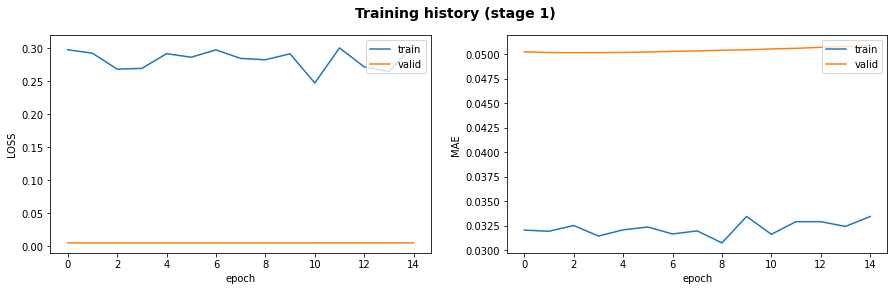

In [ ]:
train_hist = pickle.load(open(f"./temp/{EXPERIMENT_NAME}/train_history_mindiff.pkl", "rb"))

# we plot both, the LOSS and MAE
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle("Training history (stage 1)", fontsize=14, fontweight="bold")

ax1.plot(train_hist["loss"])
ax1.plot(train_hist["val_loss"])
ax1.set(xlabel="epoch", ylabel="LOSS")
ax1.legend(["train", "valid"], loc="upper right")

ax2.plot(train_hist["mae"])
ax2.plot(train_hist["val_mae"])
ax2.set(xlabel="epoch", ylabel="MAE")
ax2.legend(["train", "valid"], loc="upper right")


In [ ]:

# ResNet | Default 2-stage training
path_resnet_def = "./temp/resnet50/best_model_2nd_stage.h5"

# EfficientNetB2 | Default 2-stage training
path_enet_def = './temp/efficientnet_b2/best_model_2nd_stage.h5'

# Weights | Product
path_resnet_w_product = "./temp/weights_product/best_model_2nd_stage_weighted.h5"

# Weights | Max
path_resnet_w_max = "./temp/weights_max/best_model_2nd_stage_weighted.h5"

# MinDiff
path_resnet_mindiff = "./temp/mindiff/best_model_mindiff.h5"

# EfficientNetB2 | MinDiff
path_enet_mindiff = "./temp/efficientnet_b2/best_model_mindiff.h5"

# CustomLoss | ResNet50
path_resnet_c_loss = "./temp/custom_loss/best_model_1st_stage_custom_loss.h5"

# EfficientNetB2 | Custom Loss
path_enet_c_loss = "./temp/efficientnet_b2/best_model_1st_stage_custom_loss.h5"

# EfficientNetB2 | Weighted
path_enet_weighted = "./temp/efficientnet_b2/best_model_2nd_stage_weighted.h5"

paths_dict = {
    "resnet_def": path_resnet_def,
    "enet_def": path_enet_def,
    "resnet_w_product": path_resnet_w_product,
    "resnet_w_max": path_resnet_w_max,
    "resnet_mindiff": path_resnet_mindiff,
    "enet_mindiff": path_enet_mindiff,
    "resnet_c_loss": path_resnet_c_loss,
    "enet_c_loss": path_enet_c_loss,
    "enet_weighted": path_enet_weighted,
}

In [ ]:
# for each model, calculate the MAE on the validation set
mae_dict = {}
predictions_dict = {}
for key, path in paths_dict.items():
    if "enet" in key:
        mae_error, predictions = mae_evaluation(path, X_valid_enet, Y_valid, verbose=False, return_prediction=True)
    else:
        mae_error, predictions= mae_evaluation(path, X_valid_resnet, Y_valid, verbose=False, return_prediction=True)
    # add to dictionary
    mae_dict[key] = mae_error
    predictions_dict[key] = predictions
    print(f"{key} MAE (Validation) = %.8f" % (mae_error))

47/47 [==============================] - 5s 60ms/step
resnet_def MAE (Validation) = 6.87747658
47/47 [==============================] - 7s 73ms/step
enet_def MAE (Validation) = 4.81967559
47/47 [==============================] - 4s 57ms/step
resnet_w_product MAE (Validation) = 11.01833042
47/47 [==============================] - 4s 57ms/step
resnet_w_max MAE (Validation) = 8.28580062
47/47 [==============================] - 4s 57ms/step
resnet_mindiff MAE (Validation) = 7.14506327
47/47 [==============================] - 6s 68ms/step
enet_mindiff MAE (Validation) = 5.09042434
47/47 [==============================] - 4s 57ms/step
resnet_c_loss MAE (Validation) = 6.85389468
47/47 [==============================] - 6s 68ms/step
enet_c_loss MAE (Validation) = 5.15630011
47/47 [==============================] - 6s 68ms/step
enet_weighted MAE (Validation) = 4.74446923


In [ ]:
# making predictions on the TEST data
path = paths_dict["enet_weighted"]

saved_model = tf.keras.models.load_model(
    path,
    compile=False
)
predictions_st2_test = saved_model.predict(X_test_enet, batch_size=32, verbose=1)

# re-scaling the predictions to the range of "ages" as the outputs are in the range of [0,1]
predictions_st2_test_final = predictions_st2_test * 100


62/62 [==============================] - 7s 75ms/step


In [ ]:
import csv

# saving the predictions as a csv file
with open('predictions.csv', 'w') as csvFile:
  writer = csv.writer(csvFile)
  writer.writerows(predictions_st2_test_final)
csvFile.close()

# compressing the csv file (to be submitted to codalab as prediction)
! zip predictions.zip predictions.csv

updating: predictions.csv (deflated 54%)
